In [64]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import gensim
import numpy as np
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
# from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary

In [65]:
non_contex_data= pd.read_csv('mx-train-data-non-contextual.csv')
non_contex_data.head()

,tweet:text
0,Soy el Clint Eastwood de los Puentes de Madiso...
1,"Actualmente ya pasó de moda la pucha joto, aho..."
2,¿Es cierto esto? Y no me refiero a lo que dijo...
3,Vuela pega y esquiva... la neta está de la ver...
4,Mejor puto disfraz de la noche!!!! 👊👊👊Por terc...


In [66]:
contex_data= pd.read_csv('mx-train-data-contextual.csv')
contex_data.head()

,tweet:text,tweet:id,account:id,account:name,account:created_at,account:verified,tweet:retweets_count,tweet:favorites_count,account:followers_count,account:friends_count,account:listed_count,account:user_favorites,account:user_statuses,account:default_profile,account:default_profile_image,tweet:datetime,tweet:is_reply,tweet:is_quote
0,Soy el Clint Eastwood de los Puentes de Madiso...,916185531444215808,854551632645832704,not_luz,Wed Apr 19 04:26:00 +0000 2017,0,0,0,1,120,0,18,75,1,0,2017-10-06 06:17:07+00:00,0,0
1,"Actualmente ya pasó de moda la pucha joto, aho...",920509390687473664,720706496879722496,l3orrego,Thu Apr 14 20:13:13 +0000 2016,0,0,3,289,240,2,14228,7557,1,0,2017-10-18 04:38:35+00:00,0,0
2,¿Es cierto esto? Y no me refiero a lo que dijo...,907905338761990145,150543906,Cinnamoon,Tue Jun 01 05:46:36 +0000 2010,0,0,0,491,1467,5,9978,14606,0,0,2017-09-13 09:54:35+00:00,1,0
3,Vuela pega y esquiva... la neta está de la ver...,928132991121068032,45450273,DonGarcia_,Sun Jun 07 23:31:00 +0000 2009,0,0,3,1968,985,20,15028,47431,0,0,2017-11-08 05:32:03+00:00,0,0
4,Mejor puto disfraz de la noche!!!! 👊👊👊Por terc...,927062194478559232,177383115,becerrilxa,Thu Aug 12 00:24:57 +0000 2010,0,0,1,180,206,4,112,20774,0,0,2017-11-05 06:37:05+00:00,0,0


In [67]:
# Vulgarity label for each sample in the data files mx-train-data-contextual.csv and mx-train-data-non-contextual.csv, this information will be only available for trial and training data
vul= pd.read_csv('mx-train-vulgarity-label.csv')
vul.head()


,vulgar tag
0,1
1,1
2,0
3,1
4,1


In [68]:
# ground truth labels for samples in mx-train-data-contextual.csv and mx-train-data-non-contextual.csv
vul_true= pd.read_csv('mx-train-outputs.sol')
vul_true.head()

,0
0,1
1,0
2,0
3,0
4,1


In [69]:
vul_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5059 entries, 0 to 5058
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       5059 non-null   int64
dtypes: int64(1)
memory usage: 39.6 KB


Let's focused in non_contex_data

In [70]:
non_contex_data['length']=non_contex_data['tweet:text'].apply(len)

In [71]:
non_contex_data['label']=vul

In [72]:
non_contex_data=non_contex_data.drop(non_contex_data.tail(1).index)

In [73]:
non_contex_data.head()

,tweet:text,length,label
0,Soy el Clint Eastwood de los Puentes de Madiso...,103,1
1,"Actualmente ya pasó de moda la pucha joto, aho...",125,1
2,¿Es cierto esto? Y no me refiero a lo que dijo...,113,0
3,Vuela pega y esquiva... la neta está de la ver...,70,1
4,Mejor puto disfraz de la noche!!!! 👊👊👊Por terc...,71,1


In [74]:
non_contex_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5059 entries, 0 to 5058
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet:text  5059 non-null   object
 1   length      5059 non-null   int64 
 2   label       5059 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 158.1+ KB


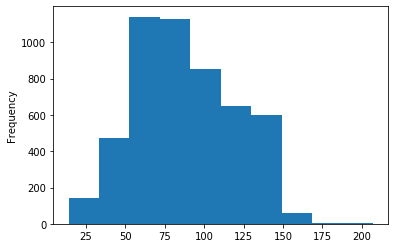

In [75]:
non_contex_data['length'].plot.hist()

In [76]:
non_contex_data['length'].describe()

count    5059.000000
mean       87.850366
std        31.248819
min        14.000000
25%        63.000000
50%        85.000000
75%       112.000000
max       207.000000
Name: length, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5c4d9e610>,
      dtype=object)

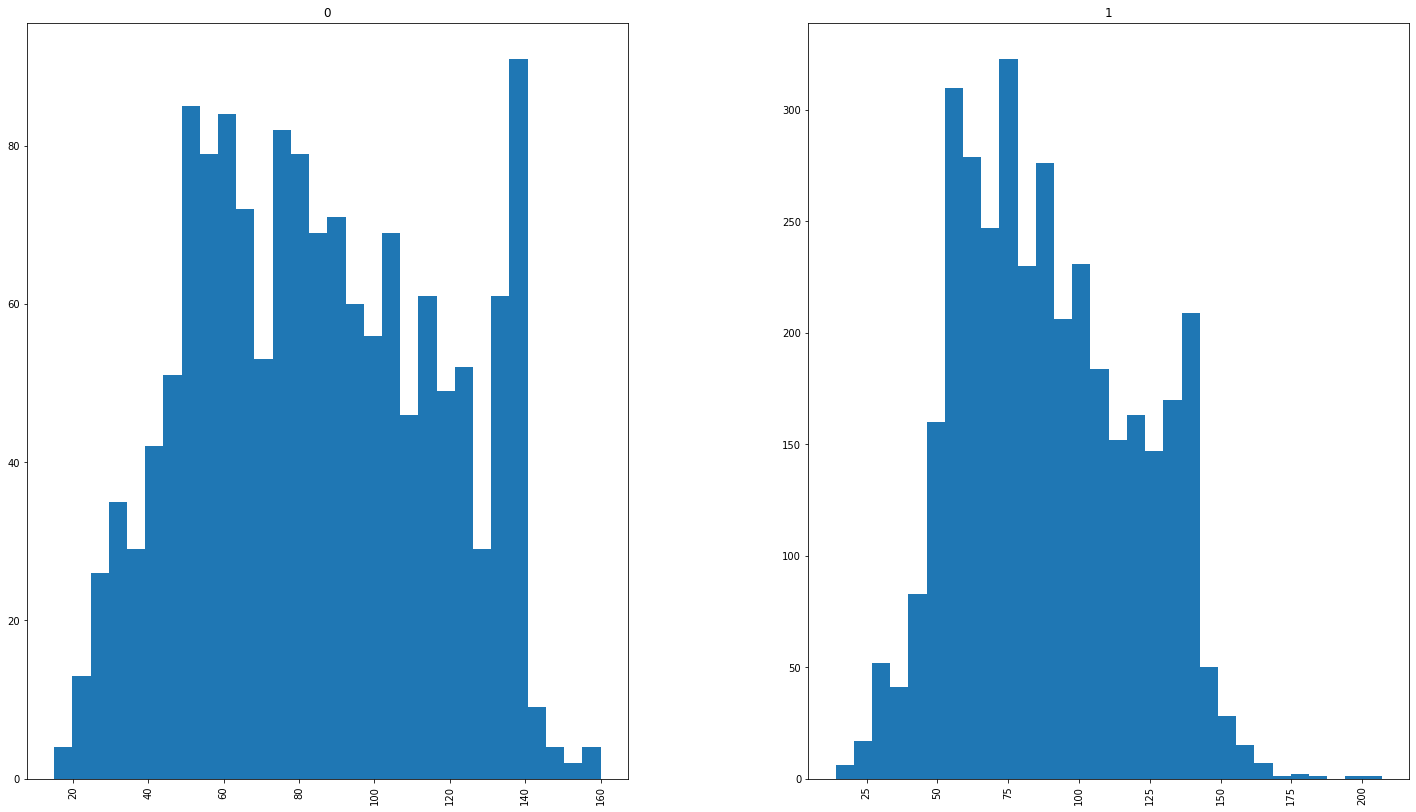

In [77]:
non_contex_data.hist(column='length', by='label', bins=30, figsize=(24,14))

Where 0 is non-offensive
 and 1 is offensive

In [78]:
import string

In [79]:
from nltk.corpus import stopwords

We're going to write a function that removes the puntuation symbols, remove stop words and returned a clean list of words


In [80]:
def text_process(mess):
    """
    1.remove punc
    2.remove stop words
    3.return list of clean text words
    """
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('spanish')]

In [81]:
non_contex_data['tweet:text'].head(5).apply(text_process)

0    [Clint, Eastwood, Puentes, Madison, todas, put...
1    [Actualmente, pasó, moda, pucha, joto, ahora, ...
2    [¿Es, cierto, refiero, dijo, tweet, sino, a👉UR...
3     [Vuela, pega, esquiva, neta, vergaaaa, pegajosa]
4    [Mejor, puto, disfraz, noche, 👊👊👊Por, tercer, ...
Name: tweet:text, dtype: object

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC

In [83]:

# pipeline for text data
text_features = 'tweet:text'
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [84]:
# from sklearn.model_selection import train_test_split

# msg_train, msg_test, label_train, label_test = train_test_split(non_contex_data['tweet:text'], non_contex_data['label'], test_size=0.3)

# print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

In [85]:
# clf_pipe.fit(msg_train, label_train) 
# clf_pipe.score(msg_test, label_test)

In [86]:
non_contex_data['tweet:text']

0       Soy el Clint Eastwood de los Puentes de Madiso...
1       Actualmente ya pasó de moda la pucha joto, aho...
2       ¿Es cierto esto? Y no me refiero a lo que dijo...
3       Vuela pega y esquiva... la neta está de la ver...
4       Mejor puto disfraz de la noche!!!! 👊👊👊Por terc...
                              ...                        
5054    Que putas mierdas pasaba por mi mente cuando d...
5055    @USUARIO Alv, bien salvado el pino. Sólo tengo...
5056    Verga estoy viendo que un compañero que tuve e...
5057    Firmado por toda la pandilla de @USUARIO a tod...
5058    Pinshe profe se mamo con el examen  Todavía qu...
Name: tweet:text, Length: 5059, dtype: object

In [87]:
non_contex_data['label']

0       1
1       1
2       0
3       1
4       1
       ..
5054    1
5055    1
5056    1
5057    1
5058    1
Name: label, Length: 5059, dtype: int64

In [88]:
pipeline.fit(non_contex_data['tweet:text'],non_contex_data['label'])

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7fc5c506bef0>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [89]:
predictions = pipeline.predict(non_contex_data['tweet:text'])

In [90]:
from sklearn.metrics import classification_report


In [91]:
print(classification_report(predictions,non_contex_data['label']))

              precision    recall  f1-score   support

           0       0.53      1.00      0.69       779
           1       1.00      0.84      0.91      4280

    accuracy                           0.86      5059
   macro avg       0.76      0.92      0.80      5059
weighted avg       0.93      0.86      0.88      5059



In [92]:
print(classification_report(predictions,vul_true))

              precision    recall  f1-score   support

           0       0.16      0.73      0.26       779
           1       0.85      0.27      0.41      4280

    accuracy                           0.34      5059
   macro avg       0.50      0.50      0.34      5059
weighted avg       0.74      0.34      0.39      5059



In [100]:
predictions

array([1, 1, 1, ..., 1, 1, 1])

Now we are going to use our model with the test set to predict the labels

In [95]:
contex_data_test= pd.read_csv('mx-test-data-non-contextual.csv')
contex_data_test.head()

,tweet:text
0,"@USUARIO Si, y uno que era como de sopa de let..."
1,"Verga, creo que van a matar a algunos periodis..."
2,@USUARIO Que nivel de bancada está preparado ...
3,"A San Martín, tirilín, tirilín, se lo llevó, t..."
4,BUENAS PUTAS NOCHES PINCHES RAMEROS DE MIERDA!...


In [96]:
contex_data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2183 entries, 0 to 2182
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet:text  2183 non-null   object
dtypes: object(1)
memory usage: 17.2+ KB


In [98]:
predictions_test = pipeline.predict(contex_data_test['tweet:text'])

In [99]:
predictions_test

array([1, 1, 1, ..., 1, 1, 1])

In [101]:
df_final = pd.DataFrame()

df_final['Pred']= list(predictions_test)

df_final.head()

,Pred
0,1
1,1
2,1
3,1
4,1


In [102]:
df_final.to_csv('Non_Contextual_Mex.tsv', sep='\t', header=False, index=False)